### Прогноз значения индекса потребительских цен на период до конца 2022 года

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 33.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import locale
locale.setlocale(locale.LC_ALL, '')
from datetime import datetime
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pylab import rcParams

import plotly.express as px
import matplotlib.pyplot as plt
#%matplotlib notebook

from itertools import compress, product

#import pmdarima as pm

from pmdarima import auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

In [3]:
file = 'Индекс потребительских цен.xlsx'
x1 = pd.ExcelFile(file)
print(x1.sheet_names)
df1 = x1.parse('Sheet0', skiprows=3, index_col=None, na_values=['NA'])
#df1 = x1.parse('Sheet0', index_col=None, na_values=['NA'])

['Sheet0']


In [ ]:
df1.head()

,Временной период | Атрибуты,Значение
0,янв 2010,107.27
1,фев 2010,106.47
2,мар 2010,105.62
3,апр 2010,105.48
4,май 2010,105.80


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Временной период | Атрибуты  147 non-null    object 
 1   Значение                     147 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
fig = px.line(df1, x=df1.iloc[:,0], y=df1.iloc[:,1])
fig.show()

In [4]:
#df1.index = pd.to_datetime(df1.index)#.dt.date
df1.index = pd.to_datetime(df1.iloc[:,0])
df1 = df1.drop(['Временной период | Атрибуты'], axis=1)
#df1 = df1.drop(['anomaly'], axis=1)
#df1.index = pd.to_datetime(df1.iloc[:,0])
#df1.index = df1.index.tz_localize(None)
df1.head()

,Значение
Временной период | Атрибуты,
2010-01-01,107.27
2010-02-01,106.47
2010-03-01,105.62
2010-04-01,105.48
2010-05-01,105.80


In [ ]:
df1.describe()

,Значение
count,147.000000
mean,106.810544
std,3.997157
min,100.100000
25%,104.050000
50%,106.230000
75%,107.895000
max,119.400000


Text(0.5, 0.98, 'Мультипликативная модель')

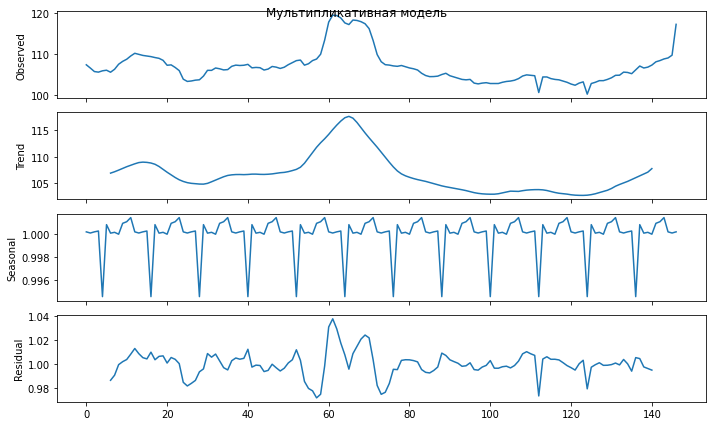

In [ ]:
# декомпозиция 
result_M = seasonal_decompose(df1['Значение'], model='multiplicative', freq=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,6)})
result_M.plot().suptitle('Мультипликативная модель')

Text(0.5, 0.98, 'Аддитивная модель')

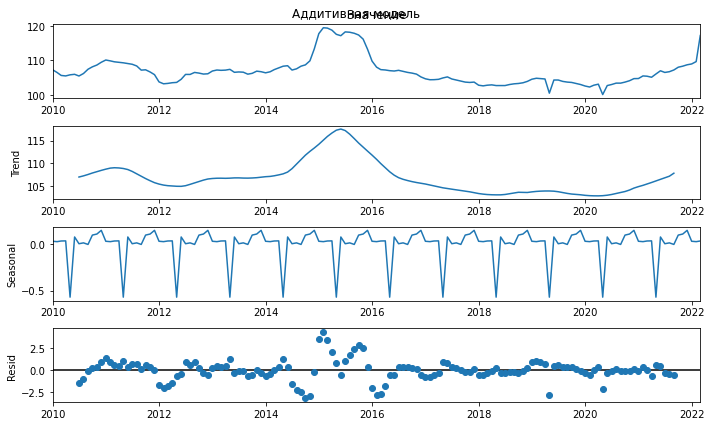

In [9]:
# декомпозиция
rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(df1['Значение'], model = 'additive')

plt.rcParams.update({'figure.figsize': (10,6)})
decomposition.plot().suptitle('Аддитивная модель')

<IPython.core.display.Javascript object>


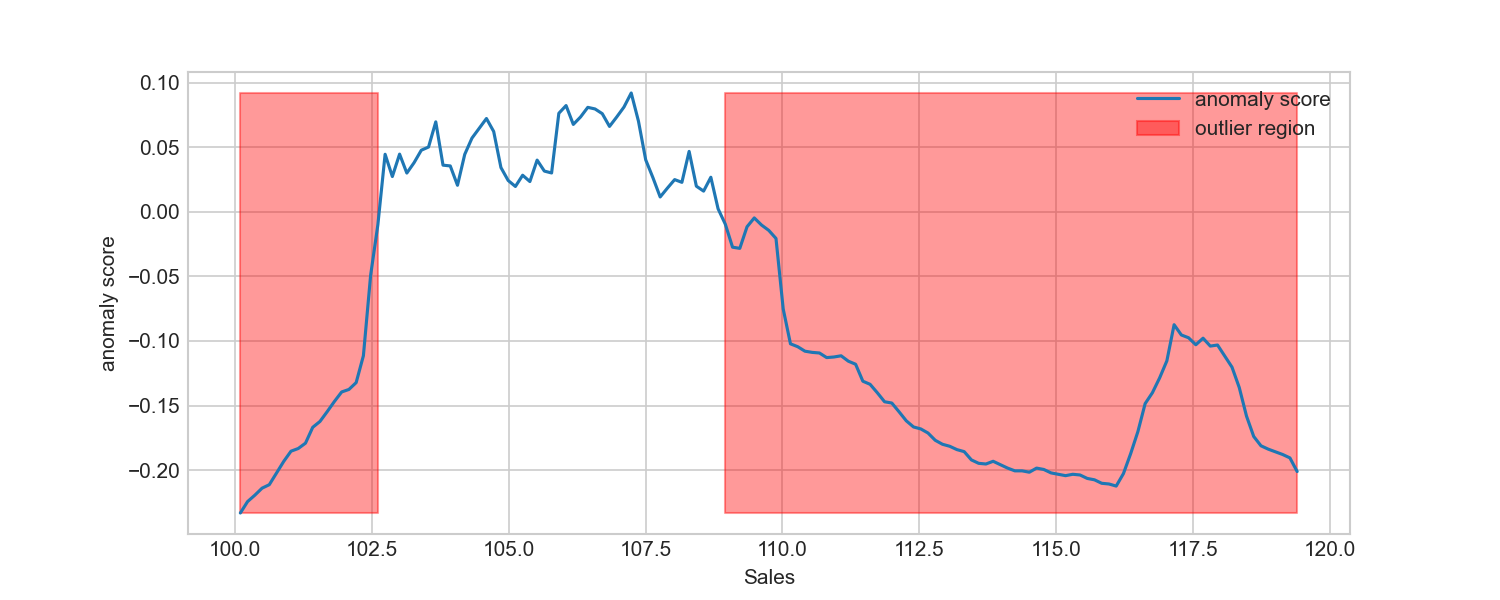

In [ ]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df1['Значение'].values.reshape(-1, 1))
xx = np.linspace(df1['Значение'].min(), df1['Значение'].max(), len(df1)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

In [ ]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [ ]:
train=df1['2010':'2021']
train.tail()

,Значение
Временной период | Атрибуты,
2021-08-01,106.7
2021-09-01,107.2
2021-10-01,108.0
2021-11-01,108.3
2021-12-01,108.7


In [ ]:
test=df1['2021':]
test.head()

,Значение
Временной период | Атрибуты,
2021-01-01,104.73
2021-02-01,105.48
2021-03-01,105.40
2021-04-01,105.10
2021-05-01,106.04


In [ ]:
# Используем модель Хольта Винтерса на исходных данных
model=ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [ ]:
model.params

{'smoothing_level': 0.8947368416350633,
 'smoothing_slope': 0.05263121311485687,
 'smoothing_seasonal': 0.10526315742453711,
 'damping_slope': nan,
 'initial_level': 106.76166338254463,
 'initial_slope': 0.13520739352485403,
 'initial_seasons': array([1.00760457, 1.00303707, 0.9981842 , 0.99252583, 0.98834716,
        0.99455033, 0.99944814, 1.00122137, 1.00241612, 1.00752832,
        1.00838715, 1.00376818]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
model.fittedvalues

Временной период | Атрибуты
2010-01-01    107.709776
2010-02-01    106.944826
2010-03-01    106.096814
2010-04-01    105.140527
2010-05-01    105.085303
                 ...    
2021-08-01    106.895546
2021-09-01    107.078077
2021-10-01    107.704010
2021-11-01    108.442549
2021-12-01    108.529994
Length: 144, dtype: float64

In [ ]:
model.forecast(15)

2022-01-01    108.717962
2022-02-01    108.851166
2022-03-01    108.718809
2022-04-01    108.418240
2022-05-01    107.521470
2022-06-01    108.599026
2022-07-01    108.489812
2022-08-01    108.890834
2022-09-01    109.307924
2022-10-01    109.866095
2022-11-01    110.299586
2022-12-01    110.539104
2023-01-01    110.572933
2023-02-01    110.705773
2023-03-01    110.568535
Freq: MS, dtype: float64

<IPython.core.display.Javascript object>


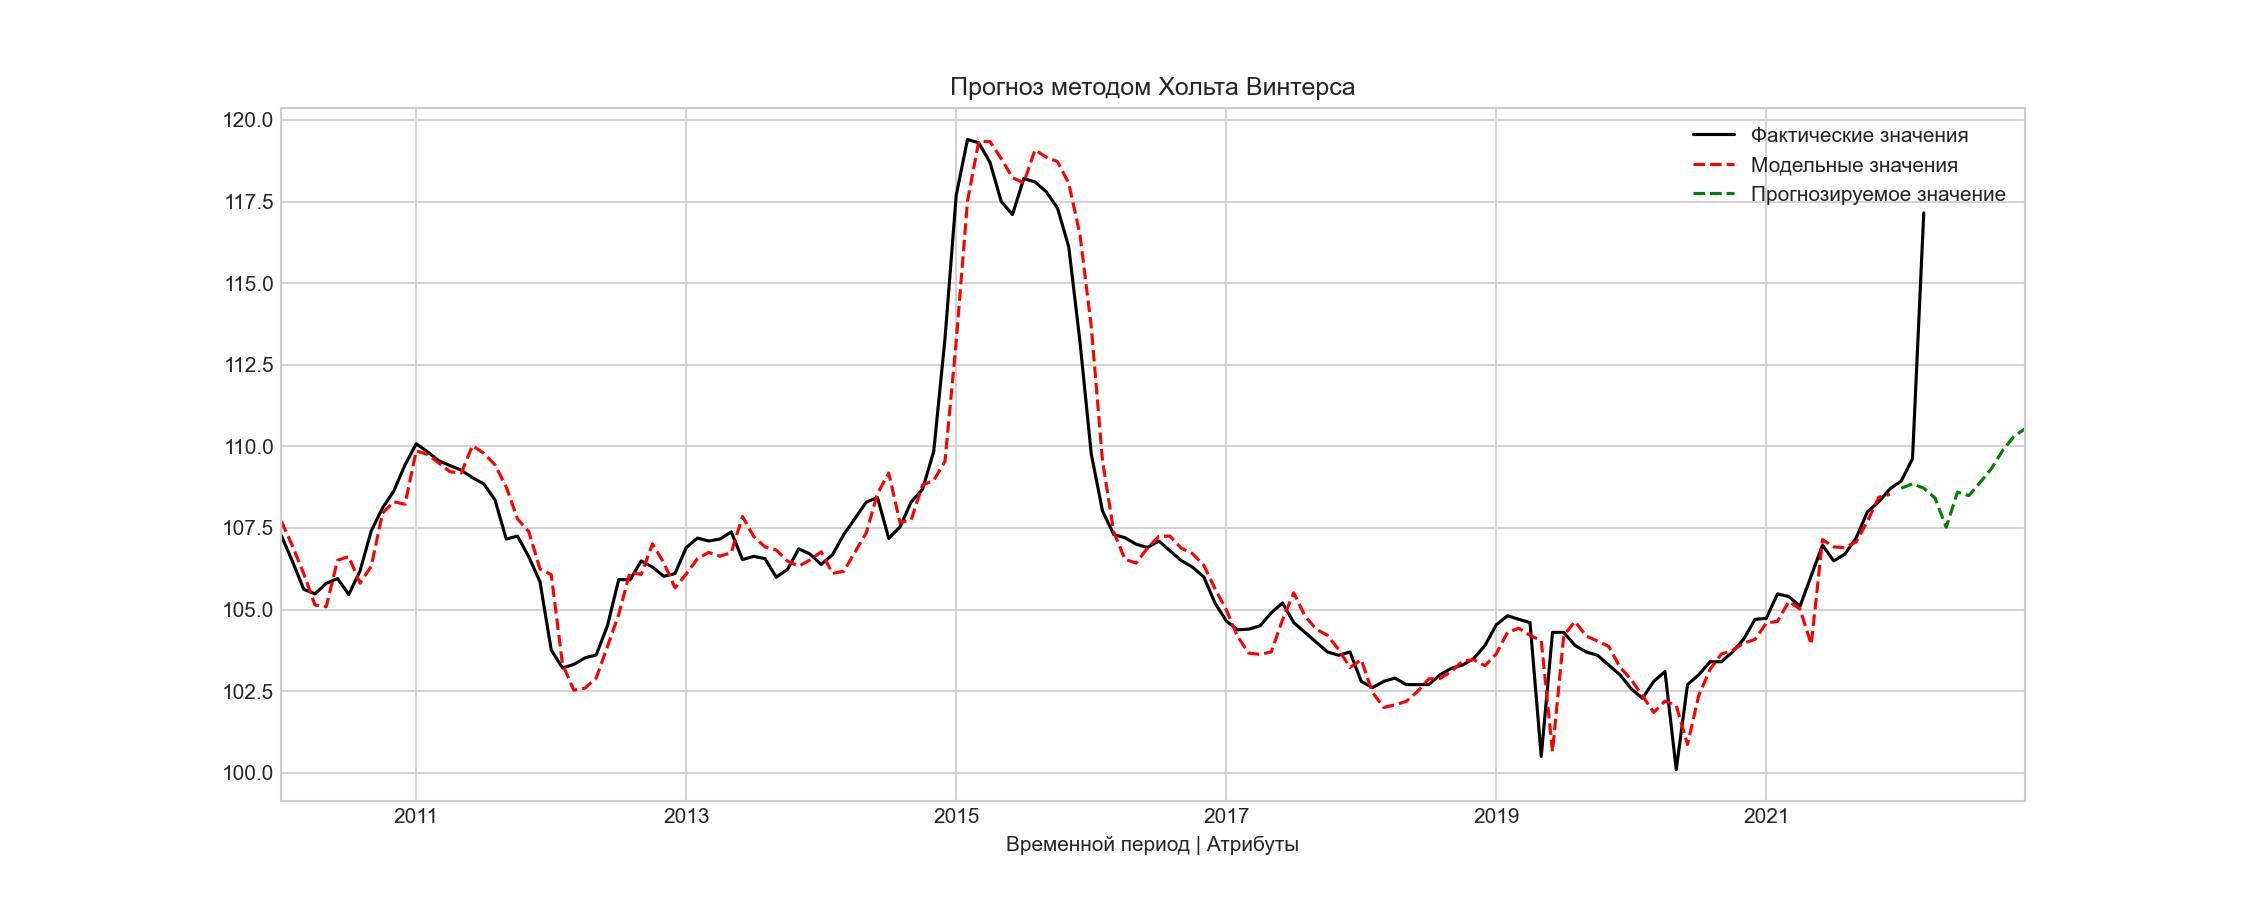

In [ ]:
ax = df1.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
model.fittedvalues.plot(ax=ax, style='--', color='red')
model.forecast(12).plot(ax=ax, style='--', color='green')
plt.legend(('Фактические значения', 'Модельные значения', 'Прогнозируемое значение'))
plt.show()

In [ ]:
metrics(train, model.fittedvalues)

Тест на стационарность:
	T-статистика = -7.818
	P-значение = 0.000
Критические значения :
	1%: -3.4769274060112707 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8819726324025625 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.577665408088415 - Данные  стационарны с вероятностью 90% процентов
MAD: 0.727
MSE: 1.1602
MAPE: 0.0068
MPE: 0.0
Стандартная ошибка: 1.0771


In [ ]:
metrics(test, model.forecast(len(test)))

Тест на стационарность:
	T-статистика = 0.791
	P-значение = 0.991
Критические значения :
	1%: -4.137829282407408 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.1549724074074077 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.7144769444444443 - Данные не стационарны с вероятностью 90% процентов
MAD: 2.5607
MSE: 8.3606
MAPE: 0.0237
MPE: -0.0162
Стандартная ошибка: 2.8915


Построим варианты модели с другими видами тренда и сезонности

In [ ]:
model2 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()
metrics(train, model2.fittedvalues)

Тест на стационарность:
	T-статистика = -7.801
	P-значение = 0.000
Критические значения :
	1%: -3.4769274060112707 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8819726324025625 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.577665408088415 - Данные  стационарны с вероятностью 90% процентов
MAD: 0.7288
MSE: 1.1636
MAPE: 0.0068
MPE: -0.0001
Стандартная ошибка: 1.0787


In [ ]:
model3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
metrics(train, model3.fittedvalues)

Тест на стационарность:
	T-статистика = -7.802
	P-значение = 0.000
Критические значения :
	1%: -3.4769274060112707 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8819726324025625 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.577665408088415 - Данные  стационарны с вероятностью 90% процентов
MAD: 0.7257
MSE: 1.1563
MAPE: 0.0067
MPE: 0.0
Стандартная ошибка: 1.0753


In [ ]:
model4 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()
metrics(train, model4.fittedvalues)

Тест на стационарность:
	T-статистика = -7.161
	P-значение = 0.000
Критические значения :
	1%: -3.4769274060112707 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8819726324025625 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.577665408088415 - Данные  стационарны с вероятностью 90% процентов
MAD: 0.9031
MSE: 1.544
MAPE: 0.0084
MPE: 0.001
Стандартная ошибка: 1.2426


Наилучшей моделью оказалась модель №1 с аддитивным трендом и мультипликативной сезонностью. У данной модели наименьшую MSE, остатки стационарны. 

In [ ]:
dftest = adfuller(df1.iloc[:,0], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.531181
p-value                          0.518034
Number of Lags Used              2.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


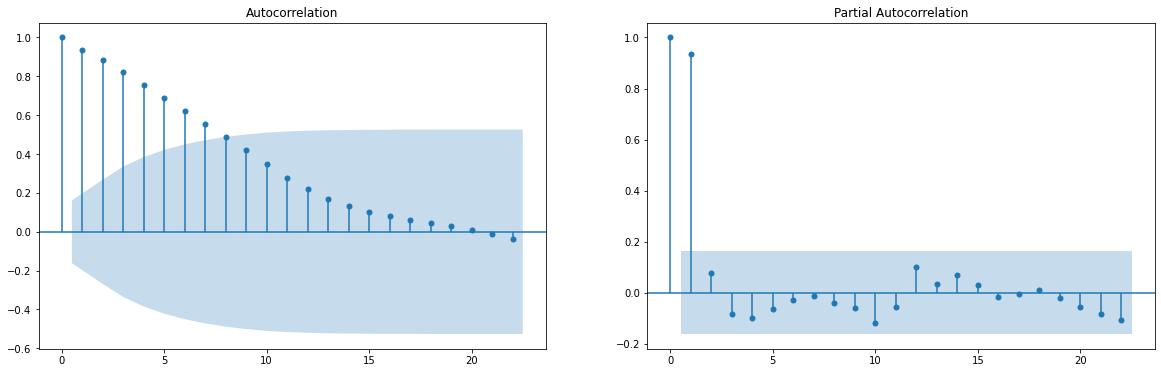

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df1.iloc[:,0], ax = ax1)
plot_pacf(df1.iloc[:,0], ax = ax2, method='ywmle')
plt.show()

In [ ]:
def check_stationary(df_):
    rollingmean=df_.rolling(12).mean()
    rollingstd=df_.rolling(12).std()
    plt.figure(figsize=(12,6))
    plt.plot(df_,color='blue',label='gold_price')
    plt.plot(rollingmean,color='black',label='mean')
    plt.plot(rollingstd,color='green',label='standard deviation') 
    plt.legend(loc='best')
    dftest=adfuller(df_,autolag='AIC')
    df_test=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    df_test
    for key,value in dftest[4].items():
        df_test['Critical Value (%s)'%key] = value
    print(df_test)

<IPython.core.display.Javascript object>


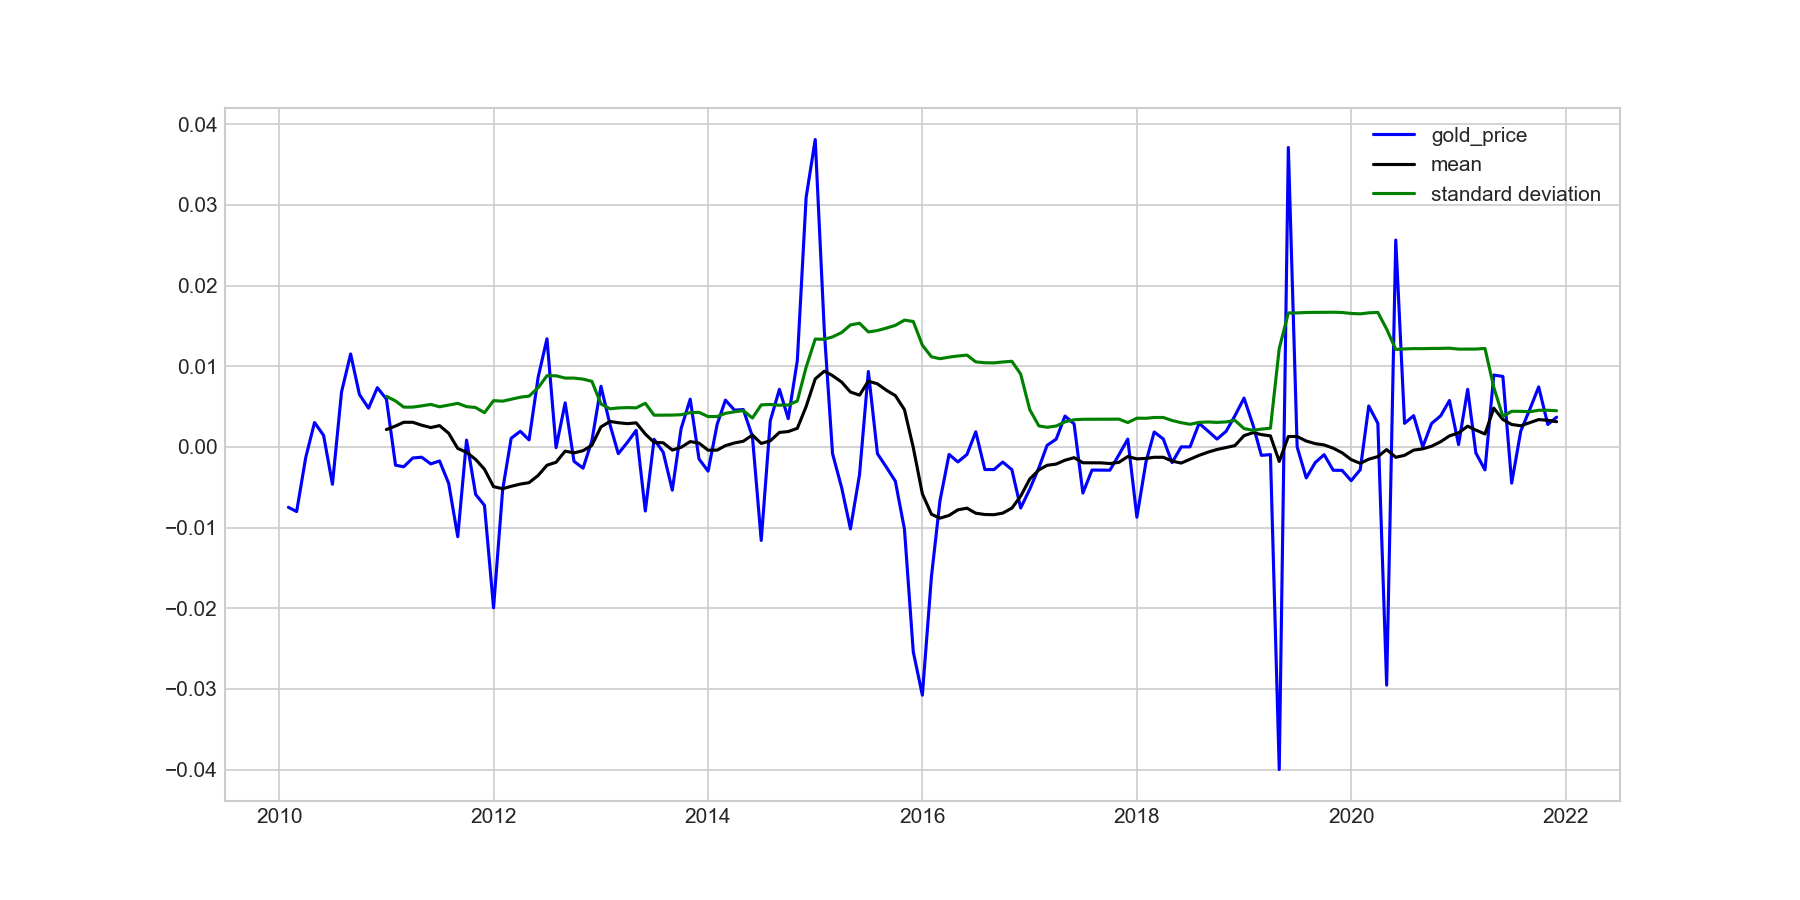

Test Statistic                -6.530373e+00
p-value                        9.904398e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.410000e+02
Critical Value (1%)           -3.477601e+00
Critical Value (5%)           -2.882266e+00
Critical Value (10%)          -2.577822e+00
dtype: float64


In [ ]:
# Приводим к стационарности
# Test statistics < Crit.Value(1%)
price_log=np.log(train)
moving_diff_shift=price_log-price_log.shift()
moving_diff_shift =moving_diff_shift.dropna()    
check_stationary(moving_diff_shift)

Критерий Дики-Фуллера для данного ряда выполняется, единичных корней нет. Подберем оптимальные параметры для модели.

In [ ]:
stepwise_model = auto_arima(df1[:'2021'], start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, d=2, D=0, 
                            trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=461.097, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=433.271, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=412.676, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=459.104, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=410.727, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=431.289, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.973 seconds
410.7273219902797


In [ ]:
nolog= ARIMA(train,order=(0,2,1))   
ogscale=nolog.fit()
og1=pd.Series(ogscale.fittedvalues,copy=True)

<IPython.core.display.Javascript object>


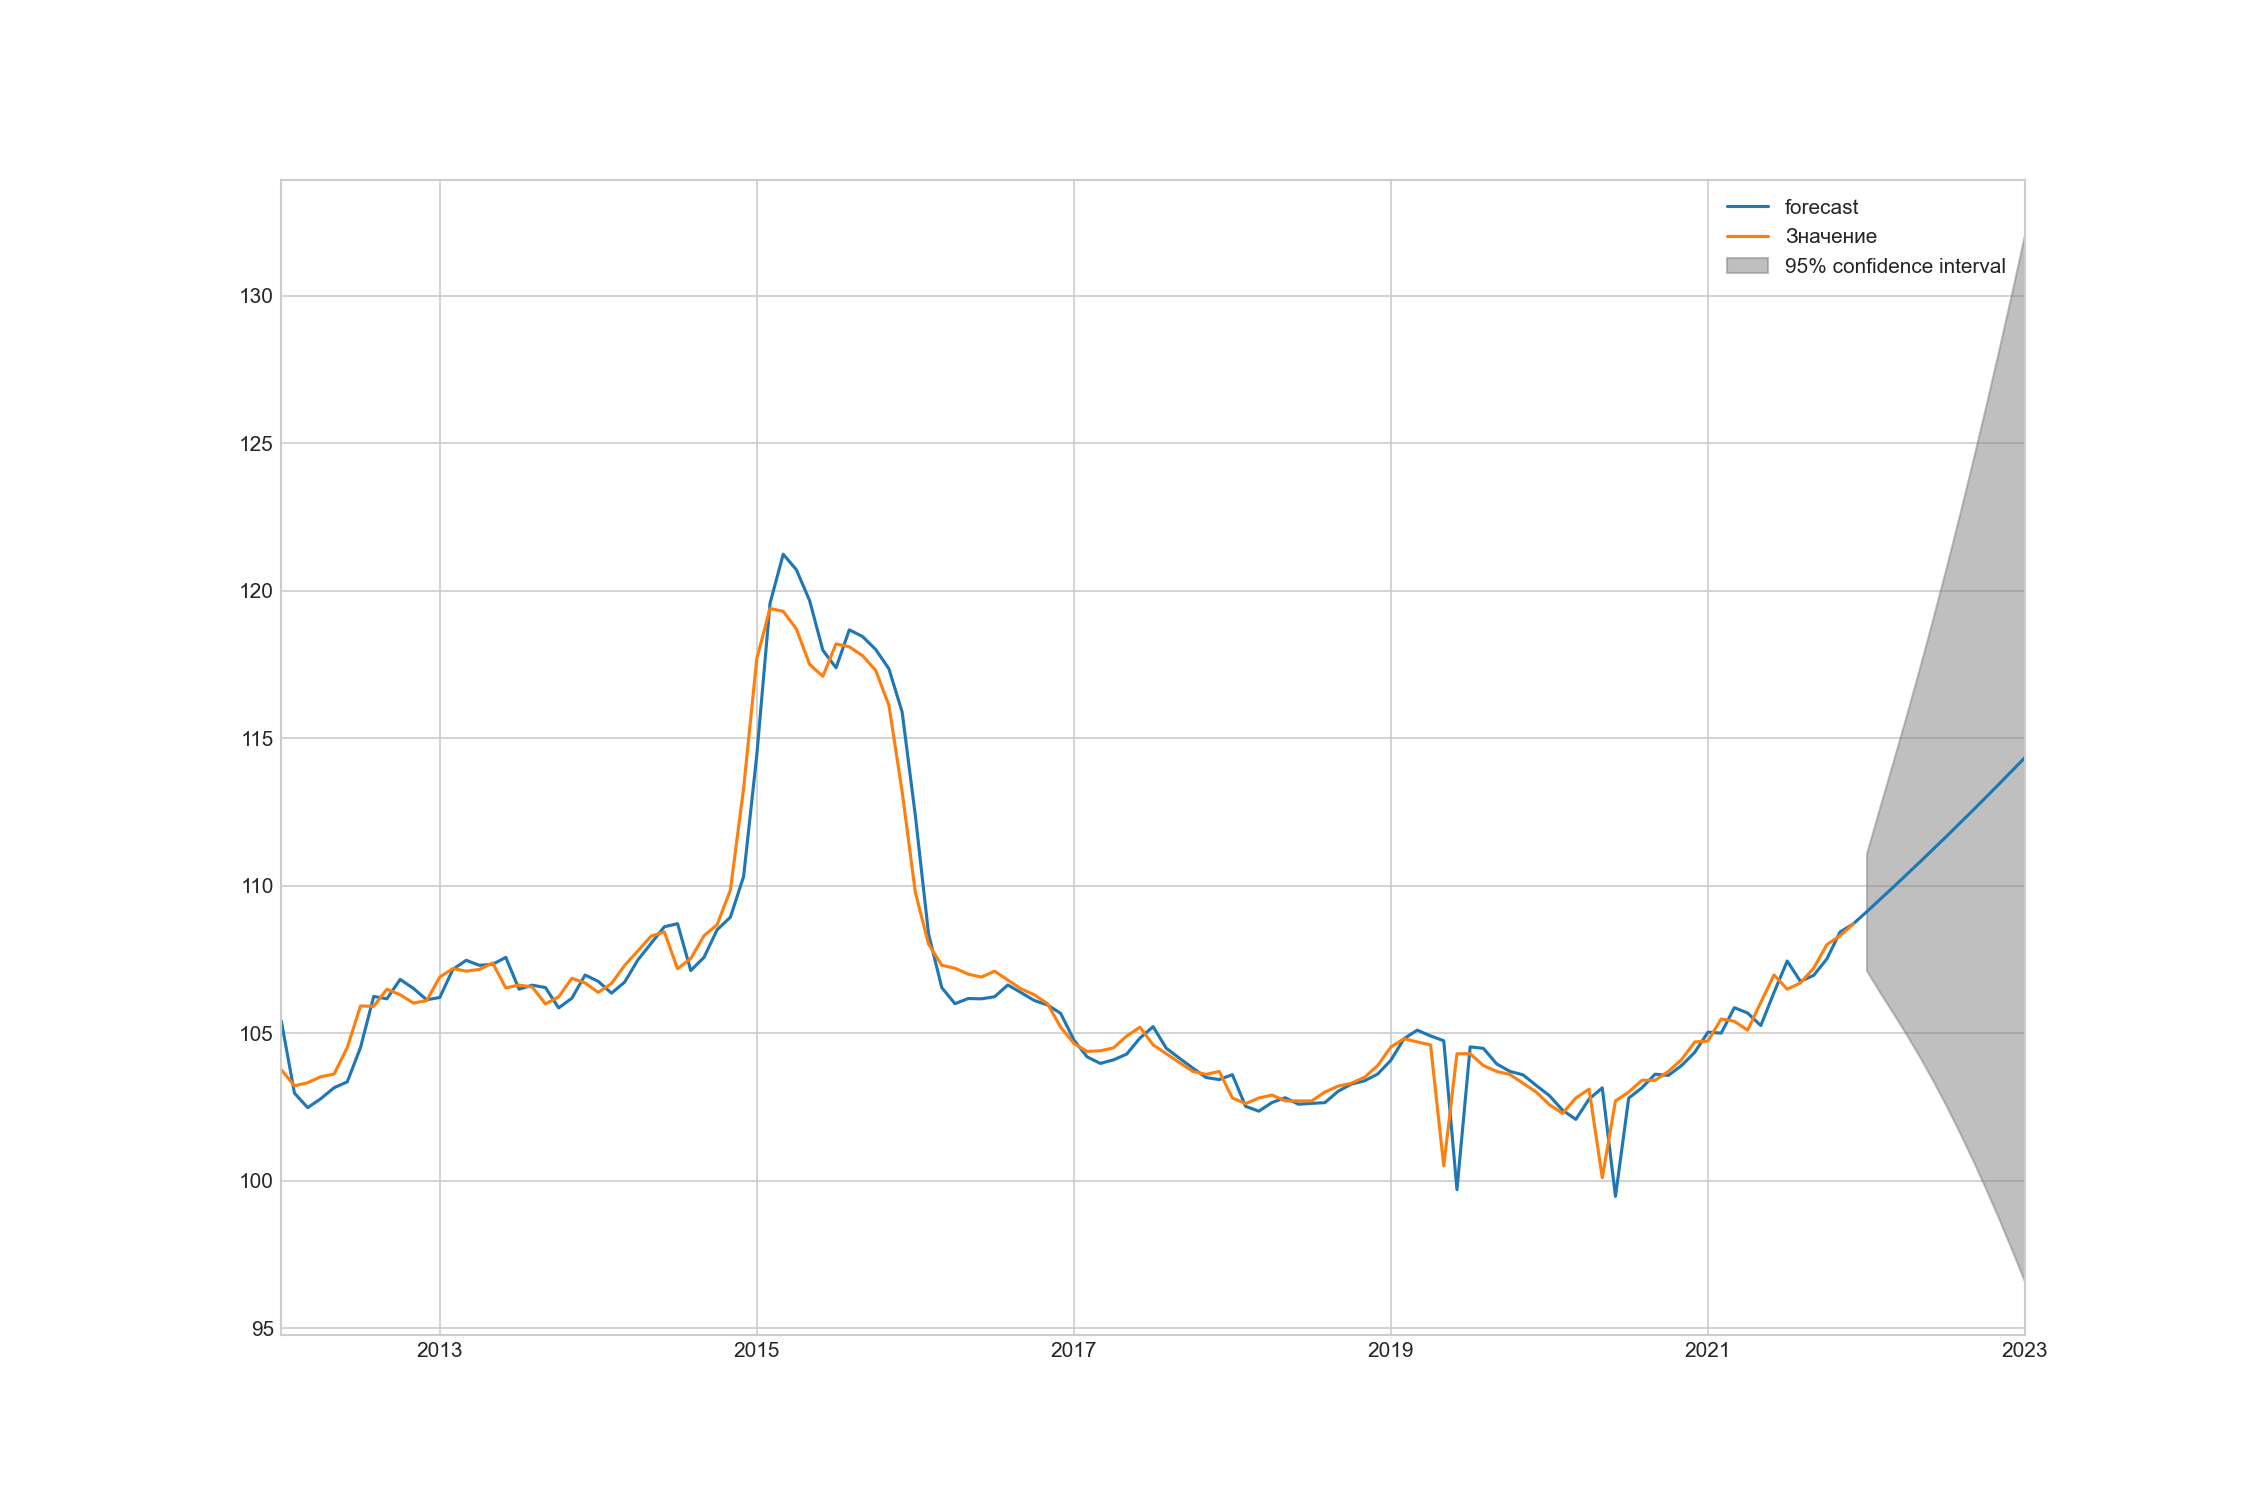

In [ ]:
og=ogscale.plot_predict('2012','2023')

In [ ]:
forecasts=ogscale.forecast(steps=12)
forecasts=pd.DataFrame(forecasts,index=['Forecast','Standard Error','Confidence Interval'])
forecasts=forecasts.transpose()
ind=pd.date_range(start='2022',freq='M',periods=12)
forecasts.index=ind
forecasts

,Forecast,Standard Error,Confidence Interval
2022-01-31,109.107773,1.009833,"[107.12853577605999, 111.08701010541519]"
2022-02-28,109.519962,1.596706,"[106.39047649333398, 112.6494475902768]"
2022-03-31,109.936567,2.166138,"[105.69101428657915, 114.18212031982766]"
2022-04-30,110.357589,2.747883,"[104.97183697652316, 115.7433404733401]"
2022-05-31,110.783026,3.350914,"[104.21535514298833, 117.35069747099183]"
2022-06-30,111.21288,3.978503,"[103.41515675531981, 119.01060334343767]"
2022-07-31,111.64715,4.631791,"[102.56900618054122, 120.72529372365402]"
2022-08-31,112.085836,5.310995,"[101.6764776246265, 122.49519440566692]"
2022-09-30,112.528938,6.0159,"[100.73799034824762, 124.31988612880443]"
2022-10-31,112.976457,6.746088,"[99.75436734826803, 126.19854589620306]"


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(test,forecasts.Forecast)

4.257190427224051